# Проект 4. Определение перспективного тарифа для телеком компании

## Описание проекта

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

<b>Тариф «Смарт»</b>
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

<b>Тариф «Ультра»</b>
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

## 1. Импорт и изучение данных

In [2]:
#Загрузим датасеты, в нужных столбцах сразу заменим тип данных на дату
calls = pd.read_csv('calls.csv', parse_dates = ['call_date'])
internet = pd.read_csv('internet.csv', parse_dates = ['session_date'])
messages = pd.read_csv('messages.csv', parse_dates = ['message_date'])
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv', parse_dates = ['reg_date'])

In [3]:
calls.head(3)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [5]:
internet.head(3)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


In [6]:
#Лишний столбец сразу удалим
internet.drop(columns = 'Unnamed: 0', inplace = True)

In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [8]:
messages.head(3)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [10]:
tariffs.head(3)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
users.head(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


In [13]:
#Заменим тип данных столбца tariff на категорию
users['tariff'] = users['tariff'].astype('category')

In [14]:
#Пропущенные значения заменим на сегодняшнее число, так как тариф еще действует
users['churn_date'] = users['churn_date'].fillna(value = '2020/05/24')
users['churn_date'] = pd.to_datetime(users['churn_date'])

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  500 non-null    datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    category      
dtypes: category(1), datetime64[ns](2), int64(2), object(3)
memory usage: 28.1+ KB


## 2. Подготовка данных

In [16]:
#Выделим месяц в отдельный столбец
calls['month'] = calls['call_date'].dt.month
calls.head(3)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6


In [17]:
#Округлим звонки до 1 минуты в большую сторону
calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'].head()

0     0.0
1     0.0
2     3.0
3    14.0
4     6.0
Name: duration, dtype: float64

In [18]:
#Создадим новую таблицу без нулевых звонков
good_calls = calls.query('duration != 0')
good_calls.head()

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9


In [19]:
#Сгруппируем таблицу по клиентам и месяцам, подсчитав кол-во и длительность звонков
df = good_calls.pivot_table(index = ['user_id', 'month'], values = ['duration'], aggfunc = ['count', 'sum']).reset_index()
df.columns = ['user_id', 'month', 'calls_count', 'calls_duration']
df.head(3)

,user_id,month,calls_count,calls_duration
0,1000,5,17,159.0
1,1000,6,28,172.0
2,1000,7,41,340.0


Округлил звонки до одной минуты в большую сторону. Причины появления нулей - либо сброс звонка либо недозвон. Возможно также это особенность тарификации входящих звонков (если они попадают в этот датасет). В любом случае, звонки с нулевой длительностью на доход с абонента не влияют, их можно удалить.

In [20]:
#Выделим месяц в отдельный столбец
internet['month'] = internet['session_date'].dt.month
internet.head(3)

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6


In [21]:
#Округлим трафик до 1 мегабайта в большую сторону
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,113.0,2018-11-25,1000,11
1,1000_1,1053.0,2018-09-07,1000,9
2,1000_2,1198.0,2018-06-25,1000,6
3,1000_3,551.0,2018-08-22,1000,8
4,1000_4,303.0,2018-09-24,1000,9


In [22]:
#Сохраним в отдельную таблицу, исключив нулевые значения
good_internet = internet.query('mb_used != 0')

Округлил трафик до 1 мегабайта в большую сторону и удалил нулевые значения. Как они появляются в датасете это вопрос, если только какие-то приложения в смартфоне, например, инициируют интернет соединение, но ничего не скачивают.

In [23]:
#Сгруппируем по клиентам помесячно и посчитаем сумму использованного трафика
internet_per_month = good_internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum').reset_index()
internet_per_month.head(3)

,user_id,month,mb_used
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0


In [24]:
len(df)

3168

In [25]:
len(internet_per_month)

3201

In [26]:
#Начнем собирать все в одну таблицу
df = pd.merge(df, internet_per_month, how = 'outer', on = ['user_id', 'month'])
df.head(3)

,user_id,month,calls_count,calls_duration,mb_used
0,1000,5,17.0,159.0,2256.0
1,1000,6,28.0,172.0,23257.0
2,1000,7,41.0,340.0,14016.0


In [27]:
len(df)

3214

In [28]:
#Cгруппируем данные по сообщениям
messages['month'] = messages['message_date'].dt.month
messages_month = messages.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count').reset_index()
messages_month.columns = ['user_id', 'month', 'messages']

In [29]:
messages_month

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [30]:
#Присоединим данные по сообшениям к общей таблице
df = pd.merge(df, messages_month, how = 'outer', on = ['user_id', 'month'])
df.head(3)

,user_id,month,calls_count,calls_duration,mb_used,messages
0,1000,5,17.0,159.0,2256.0,22.0
1,1000,6,28.0,172.0,23257.0,60.0
2,1000,7,41.0,340.0,14016.0,75.0


In [31]:
len(df)

3214

In [32]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2020-05-24,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2020-05-24,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2020-05-24,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2020-05-24,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2020-05-24,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,2020-05-24,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,2020-05-24,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,2020-05-24,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [33]:
#Здесь объединяем с параметром left, так как приоритетней левая таблица
df = pd.merge(df, users, how = 'left', on = 'user_id')
df.head()

,user_id,month,calls_count,calls_duration,mb_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,17.0,159.0,2256.0,22.0,52,2020-05-24,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,28.0,172.0,23257.0,60.0,52,2020-05-24,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,41.0,340.0,14016.0,75.0,52,2020-05-24,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,42.0,408.0,14070.0,81.0,52,2020-05-24,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,46.0,466.0,14581.0,57.0,52,2020-05-24,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [34]:
len(df)

3214

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3214 non-null   int64         
 1   month           3214 non-null   int64         
 2   calls_count     3168 non-null   float64       
 3   calls_duration  3168 non-null   float64       
 4   mb_used         3201 non-null   float64       
 5   messages        2717 non-null   float64       
 6   age             3214 non-null   int64         
 7   churn_date      3214 non-null   datetime64[ns]
 8   city            3214 non-null   object        
 9   first_name      3214 non-null   object        
 10  last_name       3214 non-null   object        
 11  reg_date        3214 non-null   datetime64[ns]
 12  tariff          3214 non-null   category      
dtypes: category(1), datetime64[ns](2), float64(4), int64(3), object(3)
memory usage: 329.7+ KB


In [36]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [37]:
df.head()

,user_id,month,calls_count,calls_duration,mb_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,17.0,159.0,2256.0,22.0,52,2020-05-24,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,28.0,172.0,23257.0,60.0,52,2020-05-24,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,41.0,340.0,14016.0,75.0,52,2020-05-24,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,42.0,408.0,14070.0,81.0,52,2020-05-24,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,46.0,466.0,14581.0,57.0,52,2020-05-24,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [38]:
#Функция, определяет доход с каждого клиента.
def revenue(data):
    
    if data['tariff'] == 'ultra':
        free_min = 3000
        free_mb = 30720
        free_sms = 1000
        fee = 1950
        rub_per_min = 1
        rub_per_gb = 150
        rub_per_sms = 1
    else:
        free_min = 500
        free_mb = 15360
        free_sms = 50
        fee = 550
        rub_per_min = 3
        rub_per_gb = 200
        rub_per_sms = 3
    
    if data['calls_duration'] <= free_min:
        price_calls = 0
    else:
        price_calls = (data['calls_duration'] - free_min)*rub_per_min
        
    if data['mb_used'] <= free_mb:
        price_internet = 0
    else:
        price_internet = (data['mb_used'] - free_mb) / 1000 * rub_per_gb
        
    if data['messages'] <= free_sms:
        price_sms = 0
    else:
        price_sms = (data['messages'] - free_sms) * rub_per_sms
    
    
    revenue = fee + price_calls + price_internet + price_sms
    return revenue

In [39]:
df['revenue'] = df.apply(revenue, axis = 1)
df.sample(5)

,user_id,month,calls_count,calls_duration,mb_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,revenue
2570,1405,12,33.0,244.0,25024.0,53.0,54,2020-05-24,Набережные Челны,Элина,Белова,2018-10-08,ultra,1950.0
2259,1363,3,98.0,841.0,20446.0,NaN,69,2020-05-24,Нижний Тагил,Оксана,Болдырева,2018-03-04,ultra,NaN
2066,1330,12,57.0,516.0,32584.0,69.0,65,2020-05-24,Нижний Новгород,Изольда,Алфимова,2018-02-02,ultra,2229.6
1982,1318,3,31.0,248.0,4054.0,14.0,53,2020-05-24,Курган,Марьяна,Анищенко,2018-03-22,ultra,1950.0
2526,1400,10,70.0,617.0,25860.0,58.0,71,2020-05-24,Москва,Ренат,Артёмов,2018-08-24,smart,3025.0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3214 non-null   int64         
 1   month           3214 non-null   int64         
 2   calls_count     3168 non-null   float64       
 3   calls_duration  3168 non-null   float64       
 4   mb_used         3201 non-null   float64       
 5   messages        2717 non-null   float64       
 6   age             3214 non-null   int64         
 7   churn_date      3214 non-null   datetime64[ns]
 8   city            3214 non-null   object        
 9   first_name      3214 non-null   object        
 10  last_name       3214 non-null   object        
 11  reg_date        3214 non-null   datetime64[ns]
 12  tariff          3214 non-null   category      
 13  revenue         2660 non-null   float64       
dtypes: category(1), datetime64[ns](2), float64(5), int64(3),

In [41]:
#Удалим лишние столбцы
df = df.drop(labels = ['age', 'first_name', 'last_name', 'reg_date', 'churn_date'], axis = 'columns')

In [42]:
df

,user_id,month,calls_count,calls_duration,mb_used,messages,city,tariff,revenue
0,1000,5,17.0,159.0,2256.0,22.0,Краснодар,ultra,1950.0
1,1000,6,28.0,172.0,23257.0,60.0,Краснодар,ultra,1950.0
2,1000,7,41.0,340.0,14016.0,75.0,Краснодар,ultra,1950.0
3,1000,8,42.0,408.0,14070.0,81.0,Краснодар,ultra,1950.0
4,1000,9,46.0,466.0,14581.0,57.0,Краснодар,ultra,1950.0
...,...,...,...,...,...,...,...,...,...
3209,1489,8,NaN,NaN,11066.0,17.0,Санкт-Петербург,smart,NaN
3210,1489,9,NaN,NaN,17232.0,32.0,Санкт-Петербург,smart,NaN
3211,1489,10,NaN,NaN,19588.0,21.0,Санкт-Петербург,smart,NaN
3212,1489,11,NaN,NaN,17516.0,20.0,Санкт-Петербург,smart,NaN


In [43]:
#Заполним пропущенные значения нулями в соответствующих столбцах
values = {'calls_count': 0, 'calls_duration': 0, 'mb_used': 0, 'messages': 0, 'revenue': 0}
df.fillna(value = values, inplace = True)

In [44]:
#Переведем тип данных в целочисленный
df['revenue'] = df['revenue'].astype('int')
df['calls_count'] = df['calls_count'].astype('int')
df['calls_duration'] = df['calls_duration'].astype('int')
df['mb_used'] = df['mb_used'].astype('int')
df['messages'] = df['messages'].astype('int')
df['user_id'] = df['user_id'].astype('int')
df['month'] = df['month'].astype('int')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   user_id         3214 non-null   int32   
 1   month           3214 non-null   int32   
 2   calls_count     3214 non-null   int32   
 3   calls_duration  3214 non-null   int32   
 4   mb_used         3214 non-null   int32   
 5   messages        3214 non-null   int32   
 6   city            3214 non-null   object  
 7   tariff          3214 non-null   category
 8   revenue         3214 non-null   int32   
dtypes: category(1), int32(7), object(1)
memory usage: 141.3+ KB


## 3. Анализ данных

In [46]:
#Выделим пользователей различных тарифов в 2 различные таблицы
smart = df.query('tariff == "smart"')
ultra = df.query('tariff == "ultra"')

In [47]:
#Преобразуем таблицу в сводную, где вычислим медианные величины для каждого пользователя тарифа smart
smart_stat = smart.pivot_table(index = 'user_id', values = ['calls_duration', 'mb_used', 'messages', 'revenue'], aggfunc = 'median')
smart_stat

,calls_duration,mb_used,messages,revenue
user_id,,,,
1001,422.0,16252.5,0.0,0.0
1002,214.0,17601.0,11.0,998.0
1005,593.5,7843.0,49.0,836.5
1006,356.0,15543.0,0.0,0.0
1007,480.0,14444.0,26.0,845.0
...,...,...,...,...
1494,411.0,17645.0,0.0,0.0
1496,524.0,24067.5,41.5,2437.0
1497,490.0,14174.0,17.0,550.0


In [48]:
#Среднее значение для таблицы с пользователями тарифа smart
mean_smart = np.mean(smart_stat)
mean_smart = mean_smart.to_frame(name = 'Среднее значение')

In [49]:
#Дисперсия для таблицы с пользователями тарифа smart
var_smart = np.var(smart_stat)
var_smart = var_smart.to_frame(name = 'Дисперсия')

In [50]:
#Стандартное отклонение для таблицы с пользователями тарифа smart
std_smart = np.sqrt(np.var(smart_stat))
std_smart = std_smart.to_frame(name = 'Стандартное отклонение')

In [51]:
#Соберем все величины в одну таблицу
stat_smart = mean_smart.join(var_smart)
stat_smart = stat_smart.join(std_smart)
stat_smart

,Среднее значение,Дисперсия,Стандартное отклонение
calls_duration,437.468571,2.561200e+04,160.037506
mb_used,16853.828571,1.741867e+07,4173.567658
messages,33.770000,7.823550e+02,27.970609
revenue,1074.854286,6.379767e+05,798.734426


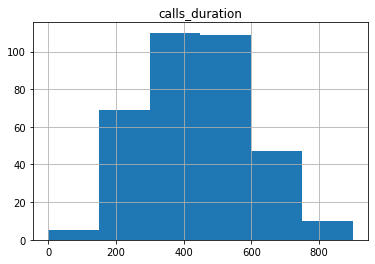

In [52]:
smart_stat.hist(column = 'calls_duration', bins = [0, 150, 300, 450, 600, 750, 900])
plt.show()

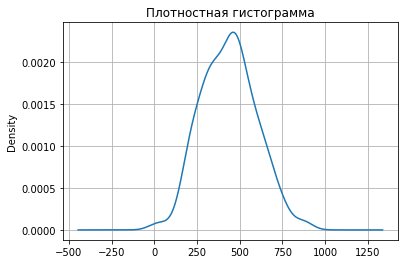

In [53]:
#Можно также построить плотностную гистограмму 
smart_stat['calls_duration'].plot.density(grid = True)
plt.title('Плотностная гистограмма')
plt.show()

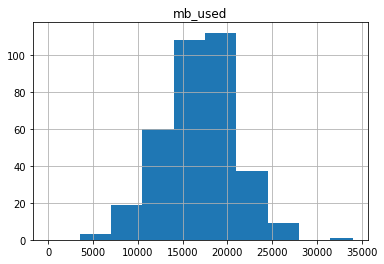

In [54]:
smart_stat.hist(column = 'mb_used', bins = [0, 3500, 7000, 10500, 14000, 17500, 21000, 24500, 28000, 31500, 34000])
plt.show()

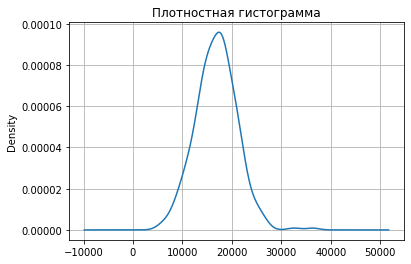

In [55]:
smart_stat['mb_used'].plot.density(grid = True)
plt.title('Плотностная гистограмма')
plt.show()

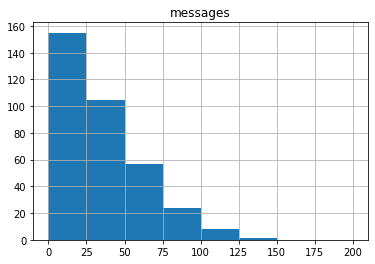

In [56]:
smart_stat.hist(column = 'messages', bins = [0, 25, 50, 75, 100, 125, 150, 175, 200])
plt.show()

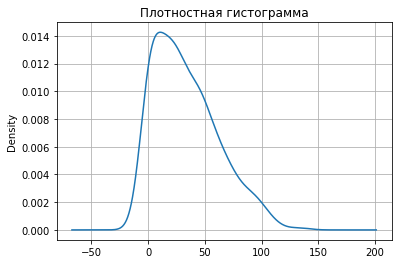

In [57]:
smart_stat['messages'].plot.density(grid = True)
plt.title('Плотностная гистограмма')
plt.show()

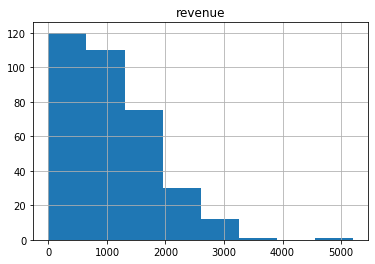

In [58]:
smart_stat.hist(column = 'revenue', bins = [0, 650, 1300, 1950, 2600, 3250, 3900, 4550, 5200])
plt.show()

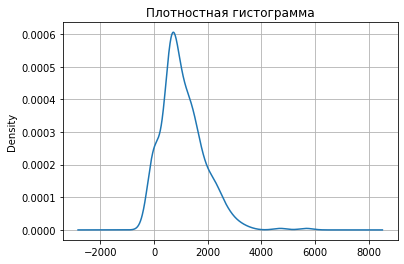

In [59]:
smart_stat['revenue'].plot.density(grid = True)
plt.title('Плотностная гистограмма')
plt.show()

## Для пользователей тарифа smart:

Для значений длительности звонков и потраченного инернет-трафика распределение нормальное.

Для значений кол-ва сообщений и ежемесячного дохода распределения Пуассона и имеют скошенность в правую сторону.

In [60]:
#Преобразуем таблицу в сводную, где вычислим медианные величины для каждого пользователя тарифа ultra
ultra_stat = ultra.pivot_table(index = 'user_id', values = ['calls_duration', 'mb_used', 'messages', 'revenue'], aggfunc = 'median')
ultra_stat

,calls_duration,mb_used,messages,revenue
user_id,,,,
1000,339.0,14325.5,65.0,1950.0
1003,824.0,11368.0,83.0,1950.0
1004,132.5,17828.5,154.5,1950.0
1013,468.0,15272.5,21.0,1950.0
1016,61.0,13417.0,71.0,1950.0
...,...,...,...,...
1476,492.0,16004.0,5.0,1950.0
1485,584.0,23447.0,155.0,1950.0
1491,531.0,17845.0,52.0,1950.0


In [61]:
#Среднее значение для таблицы с пользователями тарифа ultra
mean_ultra = np.mean(ultra_stat)
mean_ultra = mean_ultra.to_frame(name = 'Среднее значение')

In [62]:
#Дисперсия для таблицы с пользователями тарифа smart
var_ultra = np.var(ultra_stat)
var_ultra = var_ultra.to_frame(name = 'Дисперсия')

In [63]:
#Стандартное отклонение для таблицы с пользователями тарифа smart
std_ultra = np.sqrt(np.var(ultra_stat))
std_ultra = std_ultra.to_frame(name = 'Стандартное отклонение')

In [64]:
#Собираем в одну таблицу
stat_ultra = mean_ultra.join(var_ultra)
stat_ultra = stat_ultra.join(std_ultra)
stat_ultra

,Среднее значение,Дисперсия,Стандартное отклонение
calls_duration,557.503378,9.166699e+04,302.765572
mb_used,20322.489865,7.869546e+07,8871.046216
messages,56.983108,2.407883e+03,49.070186
revenue,1617.722973,7.164055e+05,846.407380


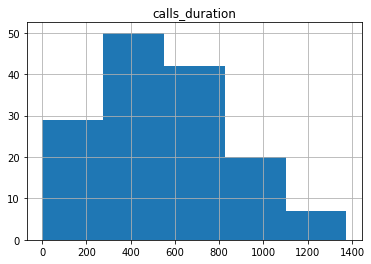

In [65]:
ultra_stat.hist(column = 'calls_duration', bins = [0, 275, 550, 825, 1100, 1375])
plt.show()

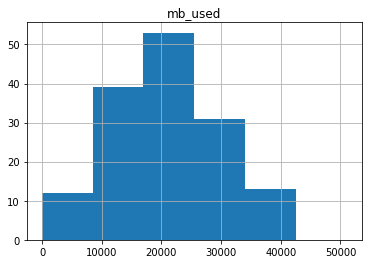

In [66]:
ultra_stat.hist(column = 'mb_used', bins = [0, 8500, 17000, 25500, 34000, 42500, 51000])
plt.show()

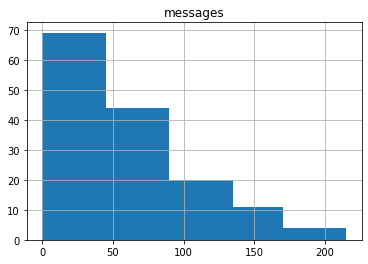

In [67]:
ultra_stat.hist(column = 'messages', bins = [0, 45, 90, 135, 170, 215])
plt.show()

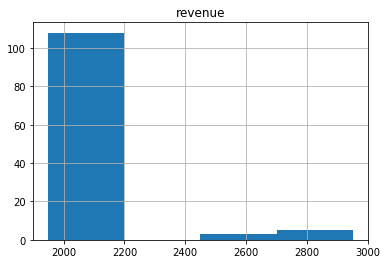

In [68]:
ultra_stat.hist(column = 'revenue', bins = [1950, 2200, 2450, 2700, 2950])
plt.show()

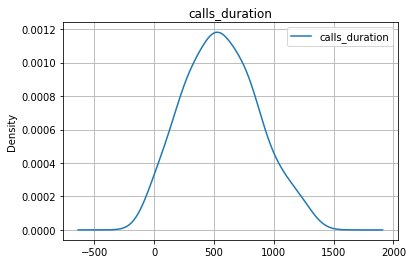

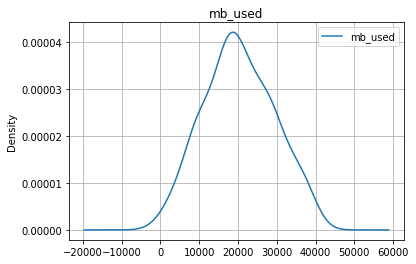

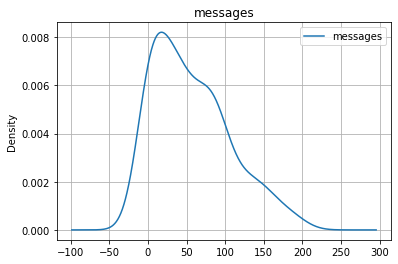

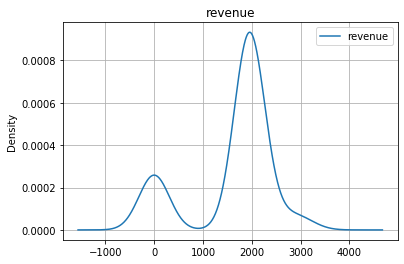

In [69]:
#Построим плотностные гистограммы для всех значений тарифа ultra
for column in ultra_stat:
    ultra_stat.plot.density(y = column, grid = True, title = column)

Вот тут на последнем графике появился интересный выброс нулевых значений. Наверно в таблице можно было бы их удалить, но по идее, они тоже влияют на показатели по выручке.

## Для пользователей тарифа ultra:

Для потраченного инернет-трафика распределение нормальное.

Для длительности звонков и кол-ва сообщений - распределения Пуассона и имеют скошенность в правую сторону.

Для выручки - при довольно высоком значении средней выручки, стандартное отклонение достаточно мало, что свидетельствует о том, что все значения сконцентрированы вокруг среднего значения, которое близко к ежемесячной абонентской платы, что позволяет сделать вывод о том, что абоненты используют крайне мало платных услуг, не включенных в ежемесячный пакет. Распределение нормальное.

In [70]:
#Сформируем сводную таблицу, для сравнения медианных величин по двум тарифам
rel_tariff = df.pivot_table(index = 'tariff', values = ['calls_duration', 'mb_used', 'messages', 'revenue'], aggfunc = 'median')
rel_tariff

,calls_duration,mb_used,messages,revenue
tariff,,,,
smart,422,16531,28,799
ultra,518,19324,38,1950


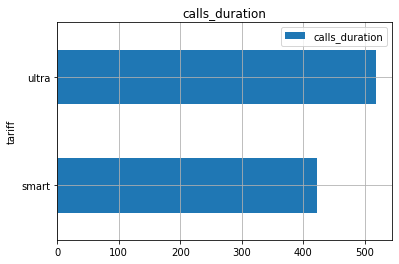

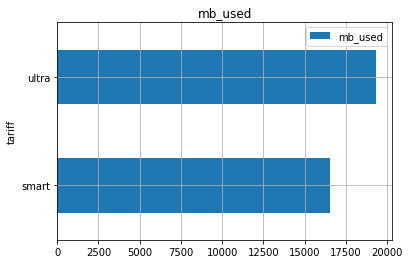

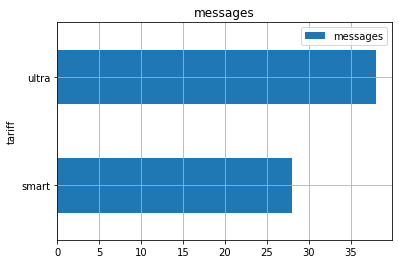

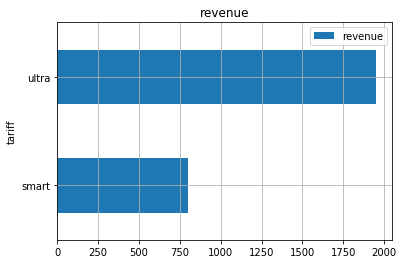

In [71]:
#Построим сравнительные графики по использованию услуг для пользователей двух тарифов
for column in rel_tariff:
    rel_tariff.plot(y = column, kind = 'barh', grid = True, title = column)

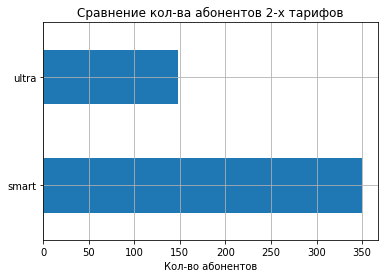

In [72]:
#Построим сравнительный график кол-ва пользователей двух тарифов
user_count = df.pivot_table(index = ['user_id', 'tariff'], values = 'calls_duration').reset_index()
user_count['tariff'].value_counts().plot(kind = 'barh', grid = True, title = 'Сравнение кол-ва абонентов 2-х тарифов')
plt.xlabel('Кол-во абонентов')
plt.show()

## Выводы по поведению пользователей двух тарифов
1. Пользователей тарифа smart более чем в 2 раза больше чем пользователей тарифа ultra, что и понятно - абонентская плата в тарифе ultra выше.
2. Пользователи тарифа smart не укладываются в пакет предоплаченных услуг, что в среднем поднимает среднемесячный (точнее медианный) доход с одного абонента до 922 рублей, при абонентской плате в 550 рублей.
3. Пользователи тарифа ultra наоборот, редко выходят за пределы абонентской платы в 1950 рублей, им хватает включенных пакетов услуг.
4. Пользователи тариф ultra больше грузят ресурсы сети (примерно на 20%): они расходуют больше трафика, дольше говорят и больше отправляют сообщений.
5. В сводную таблицу не попал 81 клиент (из 500), видимо это молчуны, которые не были активны в рассматриваемый промежуток времени.

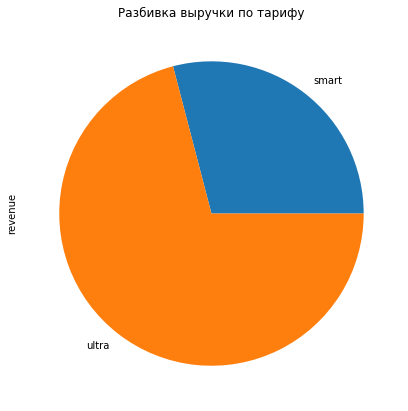

In [73]:
rel_tariff['revenue'].plot(kind = 'pie', title = 'Разбивка выручки по тарифу', figsize = (12, 7))
plt.show()

## 4. Проверка гипотез

### 4.1 Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

<b>Нулевая гипотеза</b> - средняя выручка пользователей тарифов ultra и smart одинакова. (сформулирована так, чтобы использовать знак равенства)

<b>Альтернативная гипотеза</b> - средняя выручка пользователей тарифов ultra и smart различается (противоположная по смыслу нулевой гипотезе)

In [74]:
#Выделим столбцы с доходом для двух тарифов в различные переменные
ultra_revenue = ultra['revenue']
smart_revenue = smart['revenue']

In [75]:
alpha = 0.05 #критерий значимости
results = st.ttest_ind(ultra_revenue, smart_revenue)
results.pvalue #p-значение

8.624540663073354e-45

In [76]:
#Сравним полученное методом p-значение с критерием значимости
if results.pvalue < alpha :
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


### 4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

<b>Нулевая гипотеза</b> - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. (сформулирована так, чтобы содержать знак равенства)

<b>Альтернативная гипотеза</b> - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.(противоположна по смыслу нулевой гипотезе)

In [77]:
#сформируем две таблицы с пользователями в Москве и других регионах
moscow = df.query('city == "Москва"')
regions = df.query('city != "Москва"')

In [78]:
moscow_revenue = moscow['revenue']
regions_revenue = regions['revenue']

In [79]:
alpha = 0.05 #критерий значимости
results = st.ttest_ind(moscow_revenue, regions_revenue)
results.pvalue # p-значение

0.8088181316255467

In [80]:
#Сравним полученное методом p-значение с критерием значимости
if results.pvalue < alpha :
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


### При проверке гипотез уровень статистической значимости выбран равным 0.05

## 5. Общий вывод

1. Средняя выручка пользователей тарифов smart и ultra различается - в ultra она выше в 2 раза, это подтверждают и сравнительные графики медианных величин. Таким образом, тариф "Ультра" приносит больше денег.
2. Пользователей тарифа ultra примерно в 2 раза меньше чем пользователей тарифа smart.
3. Пользователи тарифа ultra дают несколько большую нагрузку на сеть (15% - 20%).

### Исходя из перечисленного, мое предложение увеличить рекламный бюждет на тариф "Ультра", чтобы повысить число пользователей этого тарифа и как следствие увеличить выручку компании.